![alt text](lstm_nwp.png "lstm_nwp")

# LSTM Model for Next Word Prediction

**Group 1 Lily Wang**

Reference: <br>
https://towardsdatascience.com/next-word-prediction-with-nlp-and-deep-learning-48b9fe0a17bf<br>
https://towardsdatascience.com/exploring-the-next-word-predictor-5e22aeb85d8f<br>
https://thecleverprogrammer.com/2020/07/20/next-word-prediction-model/<br>
https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e<br>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

## Data preprocessing
### Clean the text
convert to form for coding

In [2]:
# data set downloaded from 'https://github.com/Bharath-K3/Next-Word-Prediction-with-NLP-and-Deep-Learning'
file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = [] # each line as an item in a long list

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


In [3]:
data = "" # change the lines list into one full string

for i in lines:
    data = ' '. join(lines)
    
# delete line breaks, the carriage return, and the Unicode character
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [4]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [5]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

In [6]:
len(data)

29361

### Tokenization

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10] # 一整个vector，每个数字对应一个单词或符号，它就是整个文本的数字版

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [9]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10] # 两个数字一对儿，代表前一个单词和后一个单词。即用前一个词估计下一个词

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [10]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [11]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [12]:
y = to_categorical(y, num_classes=vocab_size) 
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Create model

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             26170     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


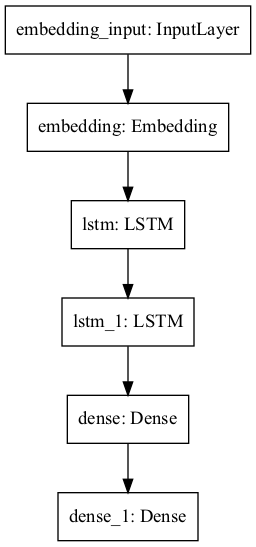

In [15]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

ModelCheckpoint — This callback is used for storing the weights of our model after training. We save only the best weights of our model by specifying save_best_only=True. We will monitor our training by using the loss metric.

ReduceLROnPlateau — This callback is used for reducing the learning rate of the optimizer after a specified number of epochs. Here, we have specified the patience as 3. If the accuracy does not improve after 3 epochs, then our learning rate is reduced accordingly by a factor of 0.2. The metric used for monitoring here is loss as well.


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

## Fit model

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=['accuracy'])

/Users/hanyiwang/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
model.fit(X, y, epochs=150, batch_size=64, validation_split=0.2,
          callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
49/49 [==============================] - 7s 94ms/step - loss: 7.8729 - accuracy: 9.6432e-04 - val_loss: 7.8831 - val_accuracy: 0.0013

Epoch 00001: loss improved from inf to 7.87290, saving model to nextword1.h5
Epoch 2/150
49/49 [==============================] - 4s 83ms/step - loss: 7.8321 - accuracy: 0.0026 - val_loss: 8.1252 - val_accuracy: 0.0026

Epoch 00002: loss improved from 7.87290 to 7.83209, saving model to nextword1.h5
Epoch 3/150
49/49 [==============================] - 4s 79ms/step - loss: 7.7417 - accuracy: 0.0039 - val_loss: 8.4485 - val_accuracy: 0.0026

Epoch 00003: loss improved from 7.83209 to 7.74169, saving model to nextword1.h5
Epoch 4/150
49/49 [==============================] - 4s 82ms/step - loss: 7.5047 - accuracy: 0.0029 - val_loss: 8.9398 - val_accuracy: 0.0026

Epoch 00004: loss improved from 7.74169 to 7.50467, saving model to nextword1.h5
Epoch 5/150
49/49 [==============================] - 4s 84ms/step - loss: 7.2861 - accuracy: 0.0019 - va

49/49 [==============================] - 4s 85ms/step - loss: 3.8220 - accuracy: 0.0842 - val_loss: 29.5113 - val_accuracy: 0.0000e+00

Epoch 00037: loss improved from 3.82413 to 3.82196, saving model to nextword1.h5
Epoch 38/150
49/49 [==============================] - 4s 83ms/step - loss: 3.7388 - accuracy: 0.0839 - val_loss: 29.9706 - val_accuracy: 0.0000e+00

Epoch 00038: loss improved from 3.82196 to 3.73877, saving model to nextword1.h5
Epoch 39/150
49/49 [==============================] - 4s 85ms/step - loss: 3.7020 - accuracy: 0.0849 - val_loss: 30.4226 - val_accuracy: 0.0000e+00

Epoch 00039: loss improved from 3.73877 to 3.70199, saving model to nextword1.h5
Epoch 40/150
49/49 [==============================] - 4s 82ms/step - loss: 3.6818 - accuracy: 0.0935 - val_loss: 30.7536 - val_accuracy: 0.0000e+00

Epoch 00040: loss improved from 3.70199 to 3.68176, saving model to nextword1.h5
Epoch 41/150
49/49 [==============================] - 4s 84ms/step - loss: 3.6487 - accuracy:

Epoch 73/150
49/49 [==============================] - 4s 86ms/step - loss: 2.0866 - accuracy: 0.3256 - val_loss: 42.4616 - val_accuracy: 0.0013

Epoch 00073: loss improved from 2.19233 to 2.08658, saving model to nextword1.h5
Epoch 74/150
49/49 [==============================] - 4s 85ms/step - loss: 2.0635 - accuracy: 0.3337 - val_loss: 42.6158 - val_accuracy: 0.0000e+00

Epoch 00074: loss improved from 2.08658 to 2.06350, saving model to nextword1.h5
Epoch 75/150
49/49 [==============================] - 4s 84ms/step - loss: 2.0393 - accuracy: 0.3427 - val_loss: 42.5363 - val_accuracy: 0.0000e+00

Epoch 00075: loss improved from 2.06350 to 2.03925, saving model to nextword1.h5
Epoch 76/150
49/49 [==============================] - 4s 84ms/step - loss: 1.9764 - accuracy: 0.3513 - val_loss: 43.2132 - val_accuracy: 0.0000e+00

Epoch 00076: loss improved from 2.03925 to 1.97639, saving model to nextword1.h5
Epoch 77/150
49/49 [==============================] - 4s 82ms/step - loss: 1.9335 - 

49/49 [==============================] - 4s 83ms/step - loss: 0.9770 - accuracy: 0.6117 - val_loss: 47.1948 - val_accuracy: 0.0000e+00

Epoch 00109: loss improved from 1.33201 to 0.97695, saving model to nextword1.h5
Epoch 110/150
49/49 [==============================] - 4s 85ms/step - loss: 0.8499 - accuracy: 0.6332 - val_loss: 48.2252 - val_accuracy: 0.0000e+00

Epoch 00110: loss improved from 0.97695 to 0.84985, saving model to nextword1.h5
Epoch 111/150
49/49 [==============================] - 4s 86ms/step - loss: 0.8014 - accuracy: 0.6390 - val_loss: 49.3083 - val_accuracy: 0.0013

Epoch 00111: loss improved from 0.84985 to 0.80138, saving model to nextword1.h5
Epoch 112/150
49/49 [==============================] - 4s 80ms/step - loss: 0.7790 - accuracy: 0.6291 - val_loss: 50.1898 - val_accuracy: 0.0000e+00

Epoch 00112: loss improved from 0.80138 to 0.77898, saving model to nextword1.h5
Epoch 113/150
49/49 [==============================] - 4s 81ms/step - loss: 0.7617 - accuracy:


Epoch 00145: loss did not improve from 0.68070
Epoch 146/150
49/49 [==============================] - 4s 84ms/step - loss: 0.6808 - accuracy: 0.6123 - val_loss: 66.7360 - val_accuracy: 0.0000e+00

Epoch 00146: loss did not improve from 0.68070

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 147/150
49/49 [==============================] - 4s 86ms/step - loss: 0.6265 - accuracy: 0.6213 - val_loss: 67.0454 - val_accuracy: 0.0000e+00

Epoch 00147: loss improved from 0.68070 to 0.62650, saving model to nextword1.h5
Epoch 148/150
49/49 [==============================] - 4s 78ms/step - loss: 0.6226 - accuracy: 0.6130 - val_loss: 67.4460 - val_accuracy: 0.0000e+00

Epoch 00148: loss improved from 0.62650 to 0.62258, saving model to nextword1.h5
Epoch 149/150
49/49 [==============================] - 4s 82ms/step - loss: 0.6205 - accuracy: 0.6201 - val_loss: 67.5745 - val_accuracy: 0.0000e+00

Epoch 00149: loss improved from 0.62258 to 0.62053, saving model to nextword1

## Evaluate the model

with tensorboard visualization

In [22]:
# tensorboard --logdir="./logsnextword1"
# http://localhost:6007/

%reload_ext tensorboard
%tensorboard --logdir="./logsnextword1"

Reusing TensorBoard on port 6006 (pid 11524), started 1:10:53 ago. (Use '!kill 11524' to kill it.)

## Predict with the model

In [20]:
# Load the model and tokenizer
model = load_model('nextword1.h5')
tokenizer = pickle.load(open('tokenizer1.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):
    for i in range(3):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = np.array(sequence)
        
        preds_ = model.predict(sequence)
        preds =np.argmax(preds_,axis=1)
        
        predicted_word = ""
        
        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        
        return predicted_word

In [21]:
# "at the dull" "collection of textile" "what a strenuous"

text = input("Enter your line: ")
text = text.split(" ")
text = text[-1]
text = ''.join(text)
Predict_Next_Words(model, tokenizer, text)

Enter your line: at the dull


'weather'